# NLP Data Exploration

### Imports 

In [1]:
import re
import unicodedata
import pandas as pd
import nltk #natural language tool kit

from env import user, password, host



Do your work for this exercise in a file named explore.

### 1. Spam Data
- Load the spam data set.
- Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
- Is there any overlap in the bigrams for the spam data and the ham data?
- Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.

### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

### Acquire 

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Prepare

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt'] #ltgt is html artifact

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#how many hams
df[df.label == "ham"].shape

(4825, 2)

In [7]:
#how many spams
df[df.label == "spam"].shape

(747, 2)

In [8]:
df.label.value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [9]:
#concatenate two diff value counts together
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [13]:
#show counts and ratios
def show_counts_and_ratios(df, column):
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    
    return labels


show_counts_and_ratios(df, 'label')

,n,percent
ham,4825,0.865937
spam,747,0.134063


Let's break the data up into 3 seperate pieces:

- The words that appear in legitimate text messages.
- The words that appear in spam text messages.
- All of the words.

In [14]:
#series of strings
df.text

id
0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object

In [15]:
#splitting a string into a list
name_parts = "jane janeway".split()

In [17]:
#joining a list/collection of strings into one string take the 
#following form
#delimiter_string.join(collection)
#" ".join(df.text)#now its all one string

In [18]:
#treat the series like a list
#calling clean function and joining everything together
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))


In [20]:
#all words
all_words[0:10]

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la']

Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how often each of the words occurs.

In [21]:
#value counts on each one of these
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()
#most frequent spam words
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [22]:
#most frequent ham words
ham_freq.head()

im      449
get     314
go      273
ok      272
dont    257
dtype: int64

Now we'll combine these three together to get one resulting data frame that we can work with:



In [24]:
#taking in three diff df will give you one df
#adding left to right
#stitching and sorting
#adding column headers
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int))) #superfluous

word_counts.tail()

,all,ham,spam
zoe,2,1,1
zogtorius,1,1,0
zoom,1,1,0
zouk,1,0,1
zyada,1,1,0


We can now use this data set to answer some interesting questions:

- What are the most frequently occuring words?

In [25]:
#sort by most frequent
#call looks to be evenly distributed by ham and spam
#spam has the word call in it alot
word_counts.sort_values(by='all', ascending=False).head(10)


,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


- Are there any words that uniquely identify a spam or ham message?


In [26]:
#concatenate them all together
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


### Visualization

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

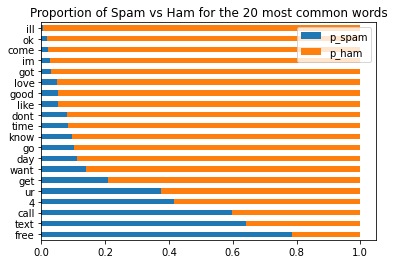

In [28]:
# figure out the percentage of spam vs ham
#taking word counts and making percentages with .assign
#sorting by all words
#labeling labels
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [29]:
#adding the ratio of spam to ham for that particular word
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


* only 15% of our entire dataset is spam

### Word Clouds

python -m pip install --upgrade wordcloud


The wordcloud allows you to identify the relative frequency of different keywords using an easily digestible visual.

Common Use Cases
- As a visualization technique, this method gives a more qualitative analysis of the topics in the documents.

Pros
1. It’s intuitive and easy to comprehend.
2. It helps identify overall respondent sentiment and the specific factors that drive it.
3. It provides direction for further analysis.
Cons
1. It fails to measure each word’s value in and of itself.
2. It allows irrelevant words to appear.
3. When words appear similar in size, it becomes difficult to differentiate them.

First we'll take a look at a simple example: